In [36]:
import os
from pathlib import Path
import pandas as pd

# For GCC_PHAT calc
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import rfft, irfft, fftfreq, fft, ifft

from itertools import combinations
from matplotlib import animation


In [37]:
# NOTE: a "frame" is the smallest unit of sampled time. (aka the data is a timeseries indexed by frame count).
# a "chunk" is a group of frames considered at a time.

# Frequency is always the same so we can hard-code it
FREQUENCY_HZ = 48000

# Always are exactly 10 seconds worth of data
# For quick testing iteration, shrink this (aka use only the first fraction of data).
N_TOTAL_FRAMES = 960 # 480000

# Consider this-many frames of frequency data at a time.
N_FRAMES_PER_CHUNK = 480

# Chunks needn't be discrete; they can overlap. If N_ADVANCE == N_F_PER_CHUNK then they are discrete.
N_ADVANCE_PER_CHUNK = 4

ANIM_LEN_SEC = 10 # 10

In [38]:
# This is a publicly-available GCC-PHAT algo.

"""
 Estimate time delay using GCC-PHAT 
 Copyright (c) 2017 Yihui Xiong

 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

import numpy as np


def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc

In [39]:
def load():
    """Load a test, and compute the phase angles over time. Eventually this will compute the geometric angles."""
    
    test_dirs = [f for f in Path("Data").iterdir() if f.is_dir()]
    
    test_0 = test_dirs[4]
    pressure_data = pd.read_csv(test_0 / "pressures.csv", index_col=0, header=0)
    display(pressure_data)
    
    positions = pd.read_csv(test_0 / "positions.csv", index_col=0, header=0)
    display(positions)
    
    def get_pair_name(mic1_idx, mic2_idx):
        """Helper to fill/access a lookup of pairwise-computed things (delays, angles)"""
        return f"{mic1_idx}.{mic2_idx}"

    def get_chunk_data_indecies(frame_idx):
        """Convert a chunk index into indecies for the pressure data."""
        return slice(frame_idx,frame_idx+N_FRAMES_PER_CHUNK,None)

    def n_frames_to_ms(n_frames):
        """Convert from some amount of frames to time in milliseconds"""
        return n_frames/FREQUENCY_HZ*1000
    
    def get_mic_pairs():
        return combinations(range(positions.shape[0]), 2)
    
    all_pairwise_delays = []
    all_delays_flattened = []
    
    
    # We process frequency timeseries in smaller chunks to get one estimated DOA angle per chunk of time.
    n_steps = 0
    for frame_idx in range(0, N_TOTAL_FRAMES - N_FRAMES_PER_CHUNK, N_ADVANCE_PER_CHUNK):
        n_steps += 1
        
        # Consider this chunk.
        this_chunk_pressure_data = pressure_data.iloc[get_chunk_data_indecies(frame_idx)]
        this_chunk_delays = []
        this_chunk_pairwise_delays = {}
        
        # Here's where we do the heavy lifting in computing phase angles for each pairing!
        for mic1_idx, mic2_idx in get_mic_pairs():
            mic1_pressure_header, mic2_pressure_header = this_chunk_pressure_data.columns[mic1_idx], this_chunk_pressure_data.columns[mic2_idx]

            s1, s2 = this_chunk_pressure_data[mic1_pressure_header], this_chunk_pressure_data[mic2_pressure_header]
            delay, _ = gcc_phat(s1, s2, FREQUENCY_HZ)
            this_chunk_delays.append(delay)
            this_chunk_pairwise_delays[get_pair_name(mic1_idx, mic2_idx)] = delay
                    
        all_pairwise_delays.append(this_chunk_pairwise_delays)
        all_delays_flattened += this_chunk_delays
     
    # Create an animation 
    fig, ax = plt.subplots()
    t_text = ax.text(0.007, 0.03, "t")
    
    # Setup the orignal line color and positions of the animation.
    # Use the last chunk done (bound to "this_chunk_pressure_data") to grab headers.
    lines = []
    for mic1_idx, mic2_idx in get_mic_pairs():
        mic1_pos = positions.iloc[mic1_idx]
        mic2_pos = positions.iloc[mic2_idx]
        m1x, m1y = tuple(mic1_pos)
        m2x, m2y = tuple(mic2_pos)
        
        # move edges right by factor of line length to remove overlaps
        xo = np.sqrt((m1x - m2x)**2 + (m1y-m2y)**2) * 0.03
        line, = ax.plot([m1x+xo, m2x+xo], [m1y, m2y], c=(1, 0, 0))
        lines.append(line)
       
    max_delay, min_delay = max(all_delays_flattened), min(all_delays_flattened)
 
    def update(chunk_idx):
        """For our animation. For each chunk create one animation frame, in which we update the line colors."""

        frame_idx = chunk_idx*N_ADVANCE_PER_CHUNK

        this_chunk_pressure_data = pressure_data[get_chunk_data_indecies(frame_idx)]
        this_chunk_pairwise_delays = all_pairwise_delays[chunk_idx]

        # For each frame, we need to recolor each edge based on the delays of this chunk.
        for line_idx, (mic1_idx, mic2_idx) in enumerate(get_mic_pairs()):
 
            delay = this_chunk_pairwise_delays[f"{mic1_idx}.{mic2_idx}"]
            
            # Since all time delays are relatively close to eachother,
            # scale the color by first normalizing then putting through an exponential.
            # Makes higher values *much* more intense.
            EXAGGERATION = 2.
            alpha = 1 if max_delay == min_delay else np.exp(EXAGGERATION*(delay - min_delay) / (max_delay - min_delay)) / (np.exp(EXAGGERATION))

            color = (1, 0, 0)
 
            lines[line_idx].set_alpha(alpha*0.6)
            lines[line_idx].set_color(color)
            t_text.set_text((
                f"Step # {chunk_idx}\n"
                f"t={n_frames_to_ms(frame_idx):.2f}ms\n"
                f"Frame # {frame_idx}\n"
                f"Chunk size:\n  {N_FRAMES_PER_CHUNK} frames ({n_frames_to_ms(N_FRAMES_PER_CHUNK):.2f}ms)\n"
                f"frame adv. per chunk:\n  {N_ADVANCE_PER_CHUNK} frames ({n_frames_to_ms(N_ADVANCE_PER_CHUNK):.2f}ms)\n"
                "Darker=longer delay"
            ))
        return *lines, t_text
    
    # Save the animation.
    ani = animation.FuncAnimation(fig, update, frames=n_steps, interval=ANIM_LEN_SEC * 1000 / n_steps)
    ani.save("anim.mp4")
    plt.gcf().set_visible(False)
    


,mic_0_pressure_Pa,mic_1_pressure_Pa,mic_2_pressure_Pa,mic_3_pressure_Pa,mic_4_pressure_Pa,mic_5_pressure_Pa,mic_6_pressure_Pa
0,-0.004150,-0.013855,-0.005035,0.000153,-0.000977,-0.000366,-0.01413
1,-0.004181,-0.013885,-0.005066,0.000122,-0.000946,-0.000366,-0.01416
2,-0.004150,-0.013855,-0.005066,0.000122,-0.000977,-0.000366,-0.01413
3,-0.004150,-0.013855,-0.005066,0.000122,-0.000977,-0.000366,-0.01413
4,-0.004150,-0.013824,-0.005066,0.000122,-0.000946,-0.000366,-0.01413
...,...,...,...,...,...,...,...
479995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
479996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
479997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
479998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


,X_meters,Y_meters
0,0.000,0.000
1,-0.029,0.071
2,0.029,-0.071
3,0.058,-0.142
4,-0.188,-0.003
5,-0.217,0.068
6,-0.159,-0.074


/tmp/ipykernel_8144/1410709382.py:37: RuntimeWarning: invalid value encountered in divide
  cc = np.fft.irfft(R / np.abs(R), n=(interp * n))


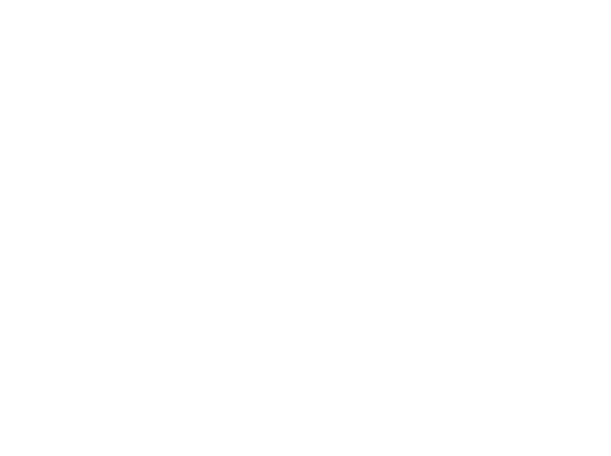

In [40]:
load()

<video width="320" height="240" controls>
  <source src="anim.mp4" type="video/mp4">
</video> 